In [37]:
# **1. Configuración inicial**
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [38]:
# Asegurar la visualización de gráficos en Jupyter
%matplotlib inline

In [39]:
# **2. Funciones**

def load_data(csv_path):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Archivo no encontrado en la ruta: {csv_path}")
    data = pd.read_csv(csv_path)
    print("Datos cargados con éxito:")
    print(data.head())
    return data


In [40]:
def group_pokemon_types(data):
    categories = {
        "Elementales": ["Agua", "Fuego", "Eléctrico", "Hielo", "Planta", "Tierra", "Roca"],
        "Místicos": ["Psíquico", "Dragón", "Fantasma", "Siniestro", "Hada", "Acero"],
        "Animales": ["Normal", "Lucha", "Volador", "Veneno", "Insecto"],
    }
    translation_dict = {
        "Water": "Agua", "Fire": "Fuego", "Electric": "Eléctrico", "Ice": "Hielo",
        "Grass": "Planta", "Ground": "Tierra", "Poison": "Veneno", "Steel": "Acero",
        "Rock": "Roca", "Dragon": "Dragón", "Ghost": "Fantasma", "Normal": "Normal",
        "Fighting": "Lucha", "Flying": "Volador", "Psychic": "Psíquico", "Bug": "Insecto",
        "Dark": "Siniestro", "Fairy": "Hada"
    }

    def map_types(type_str):
        if not type_str:
            return "Desconocido"
        translated = [translation_dict.get(t.strip(), t.strip()) for t in type_str.split(", ")]
        for category, types in categories.items():
            if any(t in translated for t in types):
                return category
        return "Desconocido"

    data['Grouped_Type'] = data['Type'].apply(map_types)
    print("\nDistribución de Tipos Agrupados:")
    print(data['Grouped_Type'].value_counts())
    return data

In [41]:
def preprocess_data(data, min_samples=5):
    X = data[['HP Base', 'Attack Base', 'Defense Base', 'Speed Base', 'Special Attack Base', 'Special Defense Base']]
    y = data['Grouped_Type']

    valid_classes = y.value_counts()[y.value_counts() >= min_samples].index
    data = data[data['Grouped_Type'].isin(valid_classes)]

    X = data[['HP Base', 'Attack Base', 'Defense Base', 'Speed Base', 'Special Attack Base', 'Special Defense Base']]
    y, classes = pd.factorize(data['Grouped_Type'])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

    return X_train, X_test, y_train, y_test, classes

In [42]:
def plot_correlation_with_categories(data):
    numeric_data = data.select_dtypes(include=[np.number])
    if numeric_data.empty:
        print("No hay datos numéricos para mostrar la matriz de correlación.")
    else:
        plt.figure(figsize=(8, 6))
        sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
        plt.title("Matriz de Correlación General")
        plt.show()

    types_dummies = data['Type'].str.get_dummies(sep=', ').add_prefix('Type_')
    types_dummies_corr = types_dummies.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(types_dummies_corr, annot=True, cmap="coolwarm")
    plt.title("Matriz de Correlación de Tipos Originales")
    plt.show()

In [43]:
def cross_validation_scores(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Scores de validación cruzada (K-Fold): {scores}")
    print(f"Precisión promedio: {scores.mean():.4f}")
    return scores.mean()

In [44]:
def optimize_random_forest(X_train, y_train):
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
    grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)
    print("Mejores parámetros para Random Forest:", grid.best_params_)
    return grid.best_estimator_


In [45]:
def train_models(X_train, X_test, y_train, y_test, classes):
    model_results = {}
    models = {
        "Logística": LogisticRegression(max_iter=500),
        "Random Forest": optimize_random_forest(X_train, y_train),
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(probability=True),
        "Naive Bayes": GaussianNB(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        "Árbol de Decisión": DecisionTreeClassifier()
    }

    for name, model in models.items():
        print(f"\n{name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = np.mean(y_test == y_pred)
        model_results[name] = acc

        print(classification_report(y_test, y_pred, target_names=classes))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
        plt.title(f"Matriz de Confusión: {name}")
        plt.show()

        # Mostrar ejemplos concretos de predicciones
        print("\n--- Ejemplos de predicciones ---")
        test_examples = pd.DataFrame(X_test[:5], columns=['HP Base', 'Attack Base', 'Defense Base', 'Speed Base', 'Special Attack Base', 'Special Defense Base'])
        test_examples['Predicción'] = [classes[label] for label in y_pred[:5]]
        test_examples['Etiqueta Real'] = [classes[label] for label in y_test[:5]]
        print(test_examples)

        # Validación cruzada K-Fold
        print(f"Validación K-Fold para {name}:")
        cross_validation_scores(model, X_train, y_train)

    return model_results


In [46]:
def plot_top_models(results):
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)[:3]
    model_names = [name for name, _ in sorted_results]
    accuracies = [accuracy for _, accuracy in sorted_results]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=model_names, y=accuracies, palette="viridis")
    plt.title("Top 3 Modelos de Aprendizaje por Precisión")
    plt.ylabel("Precisión")
    plt.xlabel("Modelos")
    plt.show()
    print("\nTop 3 Modelos:")
    for model, score in sorted_results:
        print(f"{model}: {score:.4f}")

In [47]:
def predict_with_best_model(best_model, X_sample, classes):
    predictions = best_model.predict(X_sample)
    prediction_labels = [classes[pred] for pred in predictions]
    print("Predicciones realizadas:", prediction_labels)
    return prediction_labels

Datos cargados con éxito:
          Pokemon        Type             Species         Height  \
0       Abomasnow  Grass, Ice  Frost Tree Pokémon  2.2 m (7′03″)   
1  Mega Abomasnow  Grass, Ice  Frost Tree Pokémon  2.7 m (8′10″)   
2            Abra     Psychic         Psi Pokémon  0.9 m (2′11″)   
3           Absol        Dark    Disaster Pokémon  1.2 m (3′11″)   
4      Mega Absol        Dark    Disaster Pokémon  1.2 m (3′11″)   

                 Weight                                          Abilities  \
0  135.5 kg (298.7 lbs)       1. Snow Warning, Soundproof (hidden ability)   
1  185.0 kg (407.9 lbs)                                    1. Snow Warning   
2    19.5 kg (43.0 lbs)  1. Synchronize, 2. Inner Focus, Magic Guard (h...   
3   47.0 kg (103.6 lbs)  1. Pressure, 2. Super Luck, Justified (hidden ...   
4   49.0 kg (108.0 lbs)                                    1. Magic Bounce   

              EV Yield                          Catch Rate  \
0  1 Attack, 1 Sp. Atk    60 (7.8%

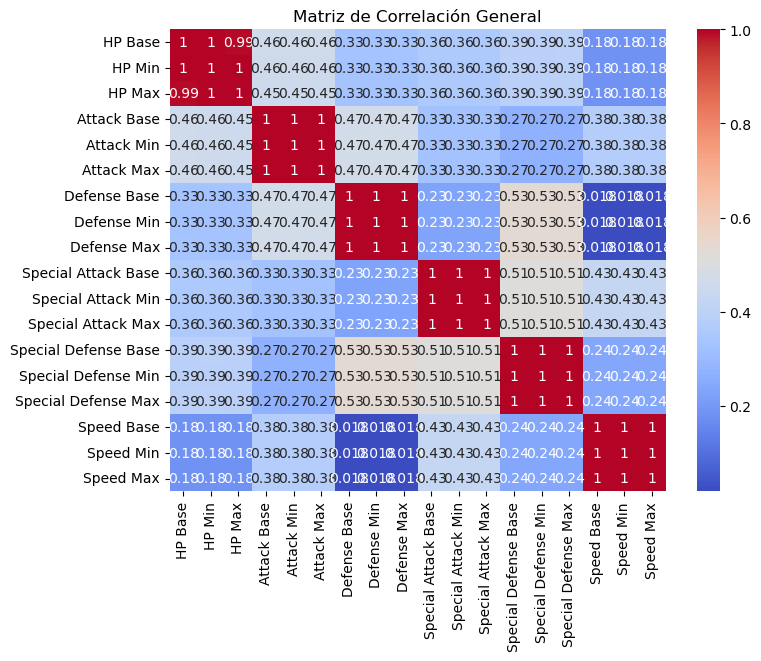

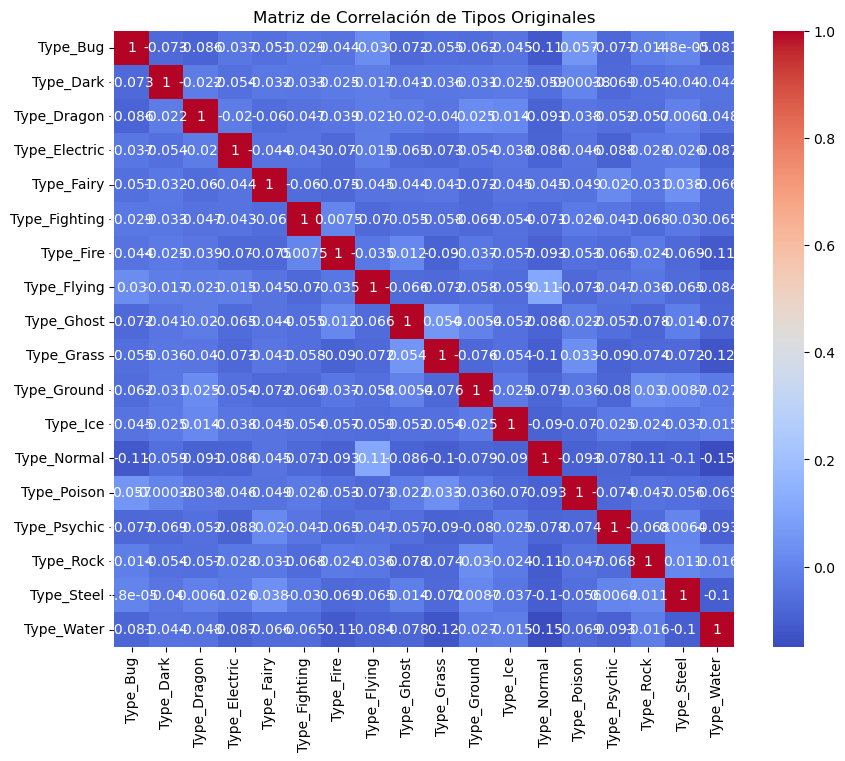

Mejores parámetros para Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Logística...
              precision    recall  f1-score   support

 Elementales       0.48      0.29      0.36       133
    Místicos       0.48      0.50      0.49       133
    Animales       0.54      0.73      0.62       133

    accuracy                           0.51       399
   macro avg       0.50      0.51      0.49       399
weighted avg       0.50      0.51      0.49       399



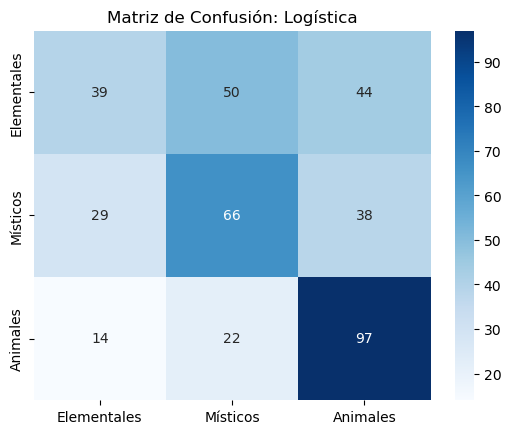


--- Ejemplos de predicciones ---
    HP Base  Attack Base  Defense Base  Speed Base  Special Attack Base  \
0 -0.603507     0.432418      1.301489   -1.162052            -0.861989   
1  0.102373    -0.192114     -0.162957    1.358771            -0.251184   
2 -0.975023     0.082124     -0.202588   -0.373226            -1.014691   
3  0.028070    -0.035981     -0.846365   -0.996208            -1.014691   
4 -0.603507     0.134435     -0.540196    1.084497            -0.855142   

   Special Defense Base   Predicción Etiqueta Real  
0             -0.995441  Elementales   Elementales  
1              0.092823     Animales      Animales  
2             -1.220994     Animales      Místicos  
3             -0.850339     Animales      Místicos  
4             -0.030806     Animales      Animales  
Validación K-Fold para Logística:
Scores de validación cruzada (K-Fold): [0.52351097 0.51410658 0.48275862 0.54716981 0.46540881]
Precisión promedio: 0.5066

Random Forest...
              precisio

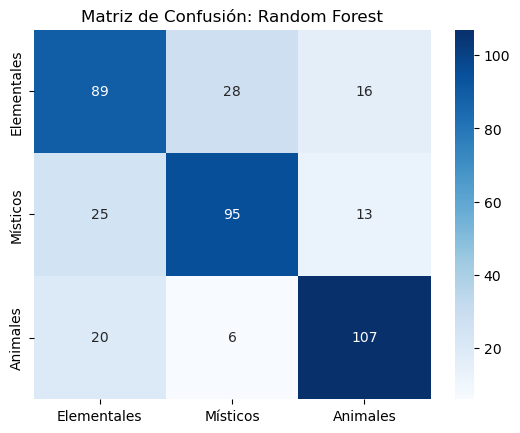


--- Ejemplos de predicciones ---
    HP Base  Attack Base  Defense Base  Speed Base  Special Attack Base  \
0 -0.603507     0.432418      1.301489   -1.162052            -0.861989   
1  0.102373    -0.192114     -0.162957    1.358771            -0.251184   
2 -0.975023     0.082124     -0.202588   -0.373226            -1.014691   
3  0.028070    -0.035981     -0.846365   -0.996208            -1.014691   
4 -0.603507     0.134435     -0.540196    1.084497            -0.855142   

   Special Defense Base   Predicción Etiqueta Real  
0             -0.995441  Elementales   Elementales  
1              0.092823     Animales      Animales  
2             -1.220994     Místicos      Místicos  
3             -0.850339     Místicos      Místicos  
4             -0.030806     Animales      Animales  
Validación K-Fold para Random Forest:
Scores de validación cruzada (K-Fold): [0.70219436 0.71159875 0.71159875 0.73584906 0.66037736]
Precisión promedio: 0.7043

KNN...
              precision    r

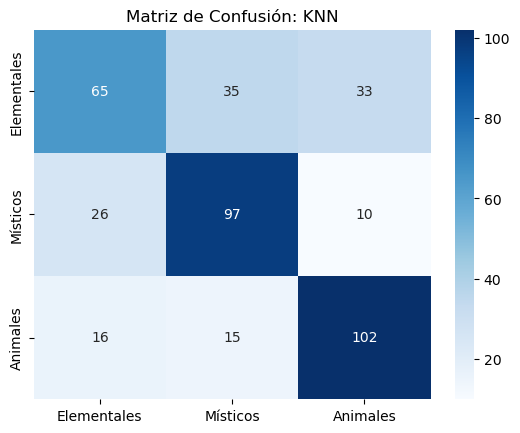


--- Ejemplos de predicciones ---
    HP Base  Attack Base  Defense Base  Speed Base  Special Attack Base  \
0 -0.603507     0.432418      1.301489   -1.162052            -0.861989   
1  0.102373    -0.192114     -0.162957    1.358771            -0.251184   
2 -0.975023     0.082124     -0.202588   -0.373226            -1.014691   
3  0.028070    -0.035981     -0.846365   -0.996208            -1.014691   
4 -0.603507     0.134435     -0.540196    1.084497            -0.855142   

   Special Defense Base   Predicción Etiqueta Real  
0             -0.995441  Elementales   Elementales  
1              0.092823     Animales      Animales  
2             -1.220994     Místicos      Místicos  
3             -0.850339     Animales      Místicos  
4             -0.030806     Animales      Animales  
Validación K-Fold para KNN:
Scores de validación cruzada (K-Fold): [0.66144201 0.64890282 0.68025078 0.69496855 0.61949686]
Precisión promedio: 0.6610

SVM...
              precision    recall  f1-

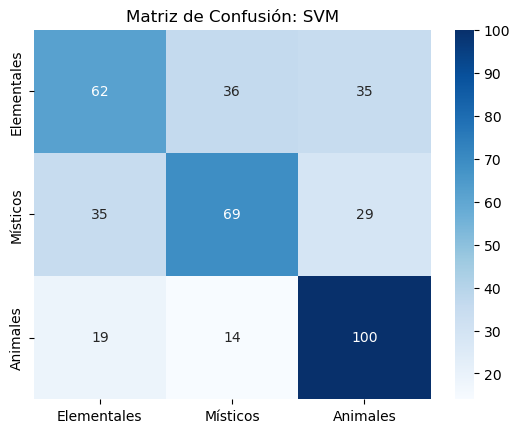


--- Ejemplos de predicciones ---
    HP Base  Attack Base  Defense Base  Speed Base  Special Attack Base  \
0 -0.603507     0.432418      1.301489   -1.162052            -0.861989   
1  0.102373    -0.192114     -0.162957    1.358771            -0.251184   
2 -0.975023     0.082124     -0.202588   -0.373226            -1.014691   
3  0.028070    -0.035981     -0.846365   -0.996208            -1.014691   
4 -0.603507     0.134435     -0.540196    1.084497            -0.855142   

   Special Defense Base   Predicción Etiqueta Real  
0             -0.995441  Elementales   Elementales  
1              0.092823     Animales      Animales  
2             -1.220994     Místicos      Místicos  
3             -0.850339     Animales      Místicos  
4             -0.030806     Animales      Animales  
Validación K-Fold para SVM:
Scores de validación cruzada (K-Fold): [0.62382445 0.60188088 0.59247649 0.60691824 0.56289308]
Precisión promedio: 0.5976

Naive Bayes...
              precision    rec

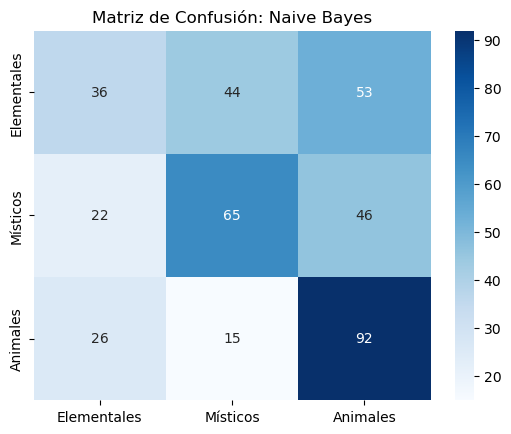


--- Ejemplos de predicciones ---
    HP Base  Attack Base  Defense Base  Speed Base  Special Attack Base  \
0 -0.603507     0.432418      1.301489   -1.162052            -0.861989   
1  0.102373    -0.192114     -0.162957    1.358771            -0.251184   
2 -0.975023     0.082124     -0.202588   -0.373226            -1.014691   
3  0.028070    -0.035981     -0.846365   -0.996208            -1.014691   
4 -0.603507     0.134435     -0.540196    1.084497            -0.855142   

   Special Defense Base   Predicción Etiqueta Real  
0             -0.995441  Elementales   Elementales  
1              0.092823     Animales      Animales  
2             -1.220994     Animales      Místicos  
3             -0.850339     Animales      Místicos  
4             -0.030806     Animales      Animales  
Validación K-Fold para Naive Bayes:
Scores de validación cruzada (K-Fold): [0.47335423 0.49216301 0.43573668 0.50314465 0.41509434]
Precisión promedio: 0.4639

XGBoost...
              precision   

c:\Users\Adrián\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


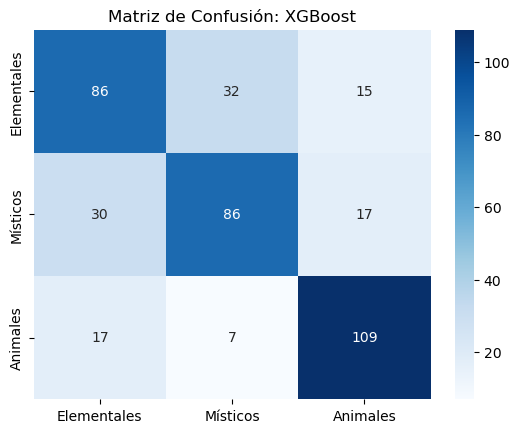


--- Ejemplos de predicciones ---
    HP Base  Attack Base  Defense Base  Speed Base  Special Attack Base  \
0 -0.603507     0.432418      1.301489   -1.162052            -0.861989   
1  0.102373    -0.192114     -0.162957    1.358771            -0.251184   
2 -0.975023     0.082124     -0.202588   -0.373226            -1.014691   
3  0.028070    -0.035981     -0.846365   -0.996208            -1.014691   
4 -0.603507     0.134435     -0.540196    1.084497            -0.855142   

   Special Defense Base   Predicción Etiqueta Real  
0             -0.995441  Elementales   Elementales  
1              0.092823     Animales      Animales  
2             -1.220994     Místicos      Místicos  
3             -0.850339     Animales      Místicos  
4             -0.030806     Animales      Animales  
Validación K-Fold para XGBoost:


c:\Users\Adrián\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Adrián\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Adrián\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Adrián\anaconda3\Lib\site-packa

Scores de validación cruzada (K-Fold): [0.67398119 0.70219436 0.6645768  0.68553459 0.6509434 ]
Precisión promedio: 0.6754

Árbol de Decisión...
              precision    recall  f1-score   support

 Elementales       0.54      0.56      0.55       133
    Místicos       0.62      0.57      0.60       133
    Animales       0.68      0.71      0.70       133

    accuracy                           0.61       399
   macro avg       0.61      0.61      0.61       399
weighted avg       0.61      0.61      0.61       399



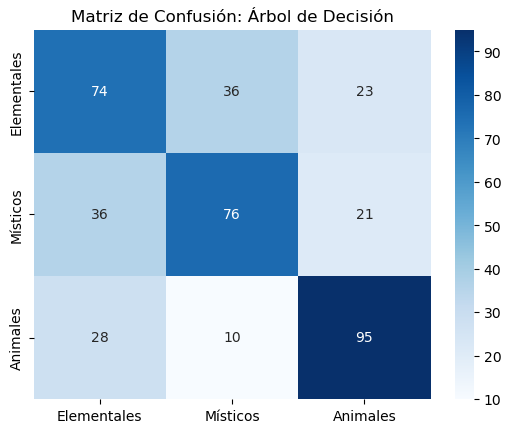


--- Ejemplos de predicciones ---
    HP Base  Attack Base  Defense Base  Speed Base  Special Attack Base  \
0 -0.603507     0.432418      1.301489   -1.162052            -0.861989   
1  0.102373    -0.192114     -0.162957    1.358771            -0.251184   
2 -0.975023     0.082124     -0.202588   -0.373226            -1.014691   
3  0.028070    -0.035981     -0.846365   -0.996208            -1.014691   
4 -0.603507     0.134435     -0.540196    1.084497            -0.855142   

   Special Defense Base   Predicción Etiqueta Real  
0             -0.995441  Elementales   Elementales  
1              0.092823     Animales      Animales  
2             -1.220994     Místicos      Místicos  
3             -0.850339     Animales      Místicos  
4             -0.030806  Elementales      Animales  
Validación K-Fold para Árbol de Decisión:
Scores de validación cruzada (K-Fold): [0.63009404 0.63322884 0.64576803 0.62578616 0.59748428]
Precisión promedio: 0.6265


C:\Users\Adrián\AppData\Local\Temp\ipykernel_3688\1549702901.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="viridis")


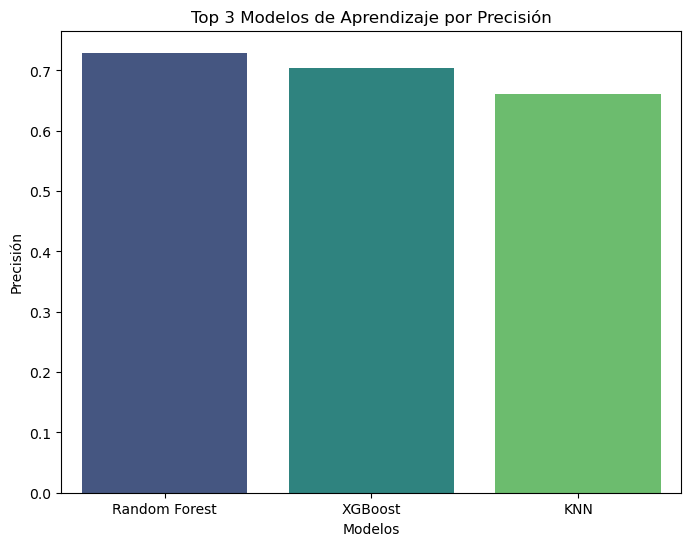


Top 3 Modelos:
Random Forest: 0.7293
XGBoost: 0.7043
KNN: 0.6617
Mejores parámetros para Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Predicciones realizadas: ['Elementales', 'Animales', 'Místicos', 'Místicos', 'Animales']


['Elementales', 'Animales', 'Místicos', 'Místicos', 'Animales']

In [48]:
# **3. Ejecución por pasos**

# Cargar datos
csv_path = 'pokemonDB_dataset.csv'
data = load_data(csv_path)

# Agrupar tipos
data = group_pokemon_types(data)

# Matrices de correlación
plot_correlation_with_categories(data)

# Preprocesar datos
X_train, X_test, y_train, y_test, classes = preprocess_data(data)

# Entrenar y evaluar modelos
model_results = train_models(X_train, X_test, y_train, y_test, classes)

# Top 3 modelos
plot_top_models(model_results)

# Predicción con el mejor modelo
best_model_name = max(model_results, key=model_results.get)
best_model = {
    "Logística": LogisticRegression(max_iter=500),
    "Random Forest": optimize_random_forest(X_train, y_train),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Árbol de Decisión": DecisionTreeClassifier()
}[best_model_name]

best_model.fit(X_train, y_train)
sample_data = X_test[:5]  # Muestra de datos para predicción
predict_with_best_model(best_model, sample_data, classes)
